# Data Gather

## Data Source
* 1.Dividend-Price Ratio
    * http://www.multpl.com/
* 2.Price-to-Earnings Ratio
    * http://www.multpl.com/
* 3.Book-to-Market
    * http://www.multpl.com/
* 4.Cyclically Adjusted Price to Earnings (CAPE)
    * http://www.multpl.com/
* 5.Bond Yields:
    * annual data: http://www.econ.yale.edu/~shiller/data/chapt26.xlsx
    * monthly data: quandl
    * daily data: https://fred.stlouisfed.org/series/DGS10/
* 6.Default spread Aaa-Baa. 
    * AAA: Quandl
    * Baa: Quandl
    * Recent Baa: Quandl
* 7.Term spread. 
    * https://fred.stlouisfed.org/series/DGS3MO
* 8.__[NOT FOUND]__Cointegration Residual of Consumption, Assets and Wealth.
* 9.VIX and OHLC daily spx prices, and VIX-vol forecast spread, as outlined in the paper.
    * quandl
* 10.Implied correlation
    * quandl
* 11.Baltic dry index
    * https://www.investing.com/indices/baltic-dry-historical-data
* 12.__[NOT FOUND]__New Orders / New Shipments data
* 13.__[NOT IMPLEMENTED]__Principal Component of Technical Indicators (PCA-tech) indicator. 
* 14.Consumer Price Index
    * quandl
* 15.__[NOT FOUND]__GSCI index in order to compute the stock-to-comodity price ratio PCR
* 16.Oil futures data. 
    * quandl EIA-PET_RCLC1_D.csv; EIA-PET_RCLC4_D.csv
* 17.Short interest data
    * quandl


# Load and construct data

In [1]:
dataset_path = "../../../market_timing_sp500/team_A/"

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def plot_factor(fac):
    if fac.isna().all():
        return
    try:
        fig, axs = plt.subplots(2,1,figsize=(12,10))
        fac.plot(ax = axs[0])
        axs[0].set_title("Time Series Look")
        sns.distplot(fac, ax =axs[1])
        axs[1].set_title("Distribution")
        plt.show()
    except:
        return

## DP (Dividend-Price Ratio)
$$DP = \frac{\text{12 month dividend per share}}{price}$$

In [4]:
df = pd.read_excel(dataset_path + "S&P_500_Dividend_Yield_by_Month.xlsx",parse_dates=[0],index_col=0).sort_index()
DP = df.Yield.astype('float').ffill()

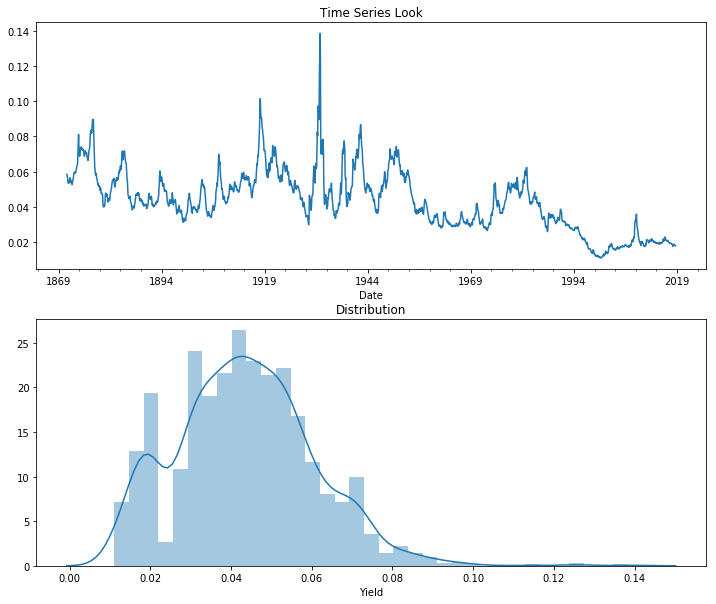

In [5]:
plot_factor(DP)

## PE (Price-to-Earnings Ratio)

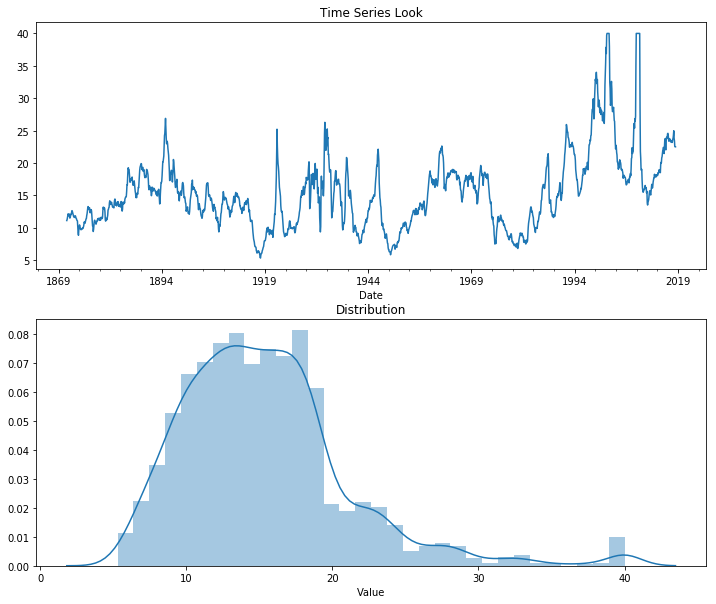

In [6]:
df = pd.read_excel(dataset_path + "S&P_500_PE_Ratio_by_Month.xlsx",parse_dates=[0],index_col=0).sort_index()
PE = df.Value.astype('float').ffill()
PE[PE>40]=40
plot_factor(PE)

## BM (Book-to-Market Ratio)

In [7]:
df = pd.read_excel(dataset_path + "S&P_500_Price_to_Book_Value_by_Quarter.xlsx",parse_dates=[0],index_col=0).sort_index()
BM = 1./df.Value.astype('float').ffill()

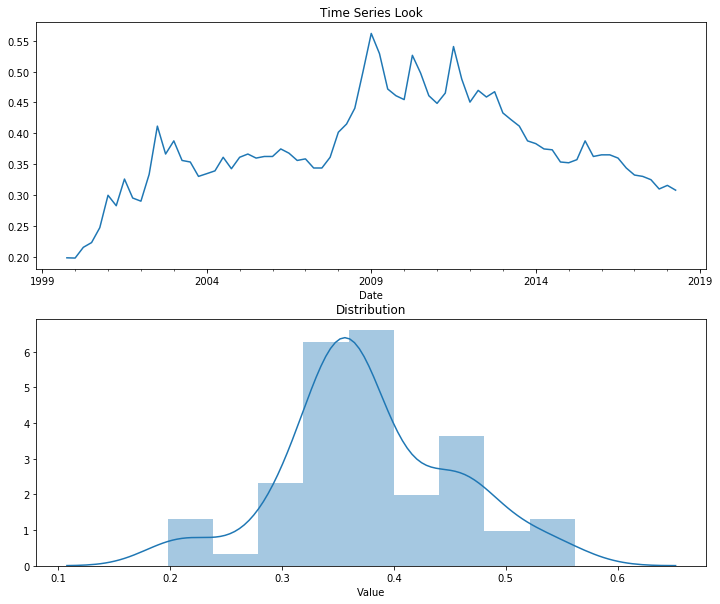

In [8]:
plot_factor(BM)

## CAPE (Cyclically Adjusted Price to Earnings Ratio)

In [9]:
df = pd.read_excel(dataset_path + "Shiller_PE_Ratio_by_Month.xlsx",parse_dates=[0],index_col=0).sort_index()
CAPE = df.Value.astype('float').ffill()

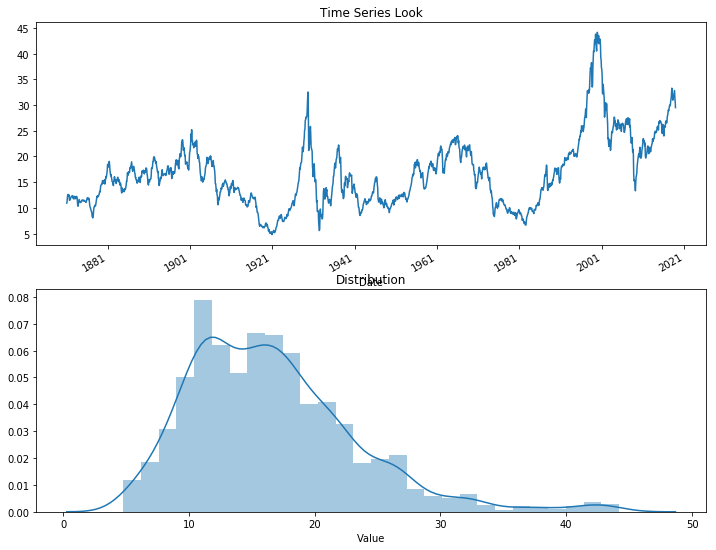

In [10]:
plot_factor(CAPE)

## PCA-price

In [11]:
from sklearn.decomposition import PCA

In [12]:
price_ratio = pd.concat([DP,PE,BM,CAPE],axis=1)
price_ratio.columns = ["DP","PE","BM","CAPE"]
price_ratio = price_ratio.ffill().reindex(CAPE.index)

In [13]:
start_date = pd.to_datetime("1990-06-08")
split_date = pd.to_datetime("2015-01-01")

In [14]:
pca = PCA(n_components=1)
train = price_ratio.loc[:split_date].dropna()
pca.fit(train)

PCA(copy=True, iterated_power='auto', n_components=1, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [15]:
test = price_ratio.dropna()

In [16]:
PCA_price = pd.Series(pca.transform(test).reshape(-1),index = test.index)

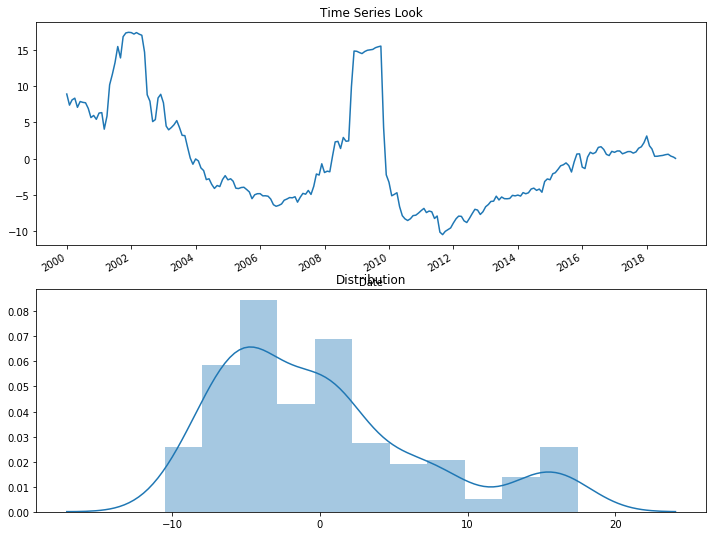

In [17]:
plot_factor(PCA_price)

## BY (Bond Yield)
$$ BY = \frac{ \text{10year Treasury bond yield} }{\text{bond yield EMA}}$$

In [18]:
df = pd.read_csv(dataset_path + "Bond_10Y_Yields_by_Day.csv")
df = df.rename(columns={"DATE":"Date"})
bond_yield_10y = df.set_index(pd.to_datetime(df.Date)).DGS10
bond_yield_10y[bond_yield_10y=='.'] = np.nan
bond_yield_10y = bond_yield_10y.ffill().astype('float')

In [19]:
BY = bond_yield_10y/bond_yield_10y.ewm(halflife=90).mean().sort_index()

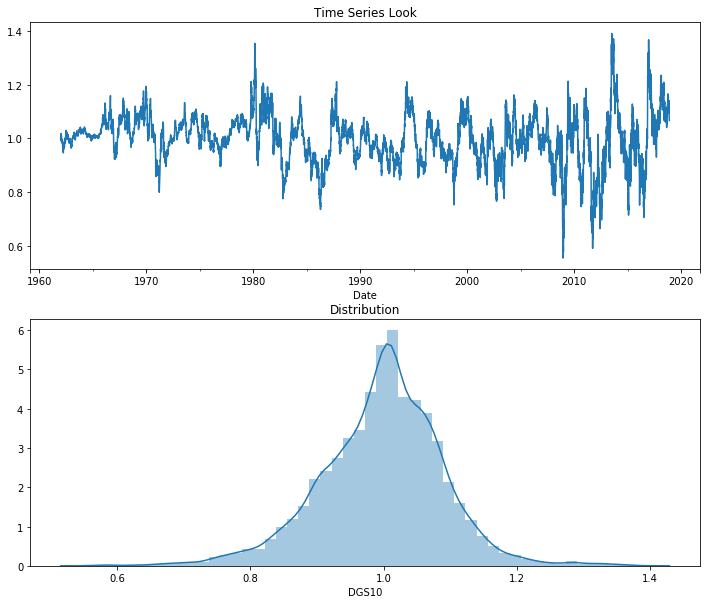

In [20]:
plot_factor(BY)

## DEF (Default Spread)
$$ DEF = \text{Baa Yield} - \text{Aaa Yield}$$

In [21]:
df = pd.read_csv(dataset_path + "Default_Spread_Baa.csv")
baa = df.set_index(pd.to_datetime(df.Date)).Value
df = pd.read_csv(dataset_path + "Default_Spread_Aaa.csv")
aaa = df.set_index(pd.to_datetime(df.Date)).Value

In [22]:
DEF = (baa - aaa).sort_index()

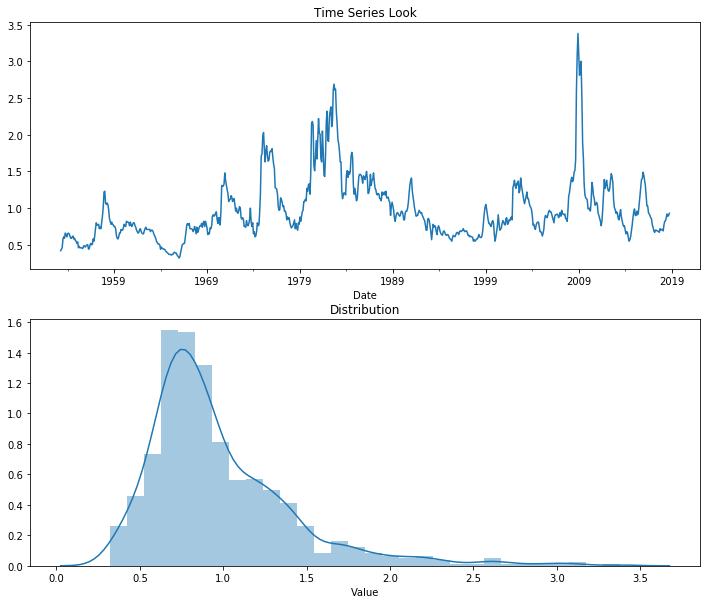

In [23]:
plot_factor(DEF)

## TERM (Term Spread)
$$ DEF = \text{10-Year Treasury Yield} - \text{3-Month Treasury Yield}$$

In [24]:
df = pd.read_csv(dataset_path + "Bond_3M_Yields_by_Day.csv")
df = df.rename(columns={"DATE":"Date"})
bond_yield_3m = df.set_index(pd.to_datetime(df.Date)).DGS3MO
bond_yield_3m[bond_yield_3m=='.'] = np.nan
bond_yield_3m = bond_yield_3m.ffill().astype('float')

In [25]:
TERM = (bond_yield_10y - bond_yield_3m).dropna().sort_index()

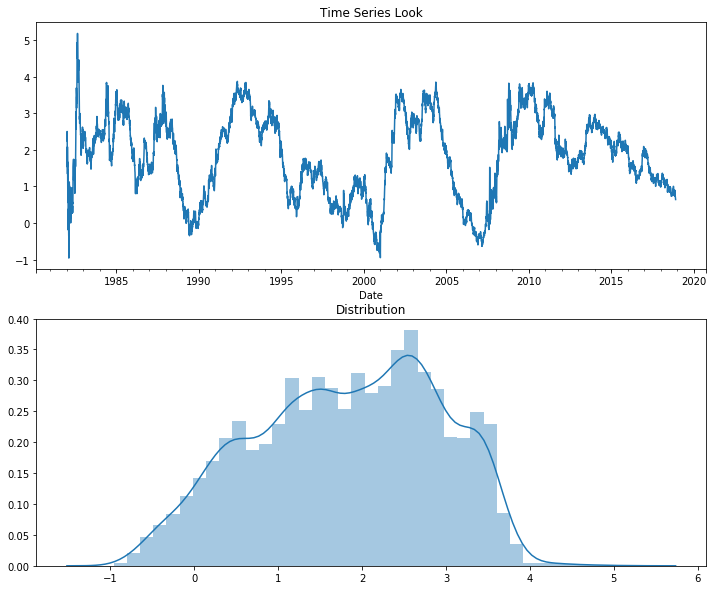

In [26]:
plot_factor(TERM)

## CAY (Cointegrating Residual of Consumption, Assets, and Wealth)

In [27]:
CAY = pd.Series(np.nan,index=DP.index)

In [28]:
plot_factor(CAY)

## SIM (Sell in May and Go Away)

$$SIM = \frac{d}{130}$$

where d is the number of days in the next 130 business days that lie between the second business day in May and the 15th business day of October.

In [29]:
import datetime
from pandas.tseries.offsets import BDay

In [30]:
def compute_d(date):
    # get next 130 business days
    startdate = date+ BDay(1)
    enddate = date+ BDay(130)
    next130bd = pd.date_range(startdate, enddate, freq= BDay())
    
    # get may to oct interval
    year = date.year
    may2st = pd.date_range('5/1/%d'%year, '5/7/%d'%year, freq='BMS')[0]+ BDay(1)
    oct15th = pd.date_range('10/1/%d'%year, '10/7/%d'%year, freq='BMS')[0]+ BDay(14)
    may2st_ = pd.date_range('5/1/%d'%(year+1), '5/7/%d'%(year+1), freq='BMS')[0]+ BDay(1)
    oct15th_ = pd.date_range('10/1/%d'%(year+1), '10/7/%d'%(year+1), freq='BMS')[0]+ BDay(14)
    interval = pd.date_range(may2st, oct15th, freq= BDay()).append(pd.date_range(may2st_, oct15th_, freq= BDay()))
    
    return len(next130bd.intersection(interval))

In [31]:
date =pd.date_range('1982-01-04', '2018-11-23', freq=BDay())
SIM = pd.Series(list(map(compute_d,date)),index = date)/130.

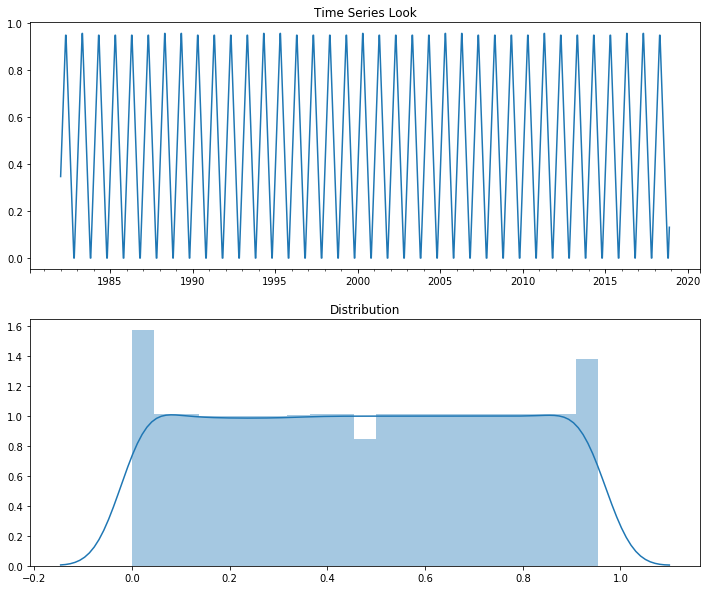

In [32]:
plot_factor(SIM)

## VRP (Variance Risk Premium)

$$VRP = \text{VIX} - \text{volatility forecast}$$

In [33]:
spx = pd.read_csv(dataset_path + "SPX.csv",parse_dates=[0]).set_index("Date")
vix = pd.read_csv(dataset_path + "VIX.csv",parse_dates=[0]).set_index("Date")
output = spx["Adj Close"]
output.rename("SPX").to_pickle("FactorData/spx.pkl")
spx = spx.reindex(vix.index)

In [34]:
spy = pd.read_csv(dataset_path + "SPY.csv",parse_dates=[0]).set_index("Date")
output = spy["Adj Close"]
output.rename("SPY").to_pickle("FactorData/spy.pkl")

In [35]:
 def estimate_vol(ohlc, window=250):
    annualized = 250
    
    vol_forecast = pd.DataFrame(columns = ["o","u","d","c"],index = ohlc.index)
    vol_forecast.loc[:,"o"] = np.log(ohlc.Open) - np.log(ohlc.Close.shift())
    vol_forecast.loc[:,"u"] = np.log(ohlc.High) - np.log(ohlc.Open)
    vol_forecast.loc[:,"d"] = np.log(ohlc.Low) - np.log(ohlc.Open)
    vol_forecast.loc[:,"c"] = np.log(ohlc.Close) - np.log(ohlc.Open)
    
    
    k = 0.34/(1.34 + (window+1)/(window-1))
    
    vo = vol_forecast.o.rolling(window=window).std(ddof=1)
    vc = vol_forecast.c.rolling(window=window).std(ddof=1)
    vrs = (vol_forecast.u*(vol_forecast.u-vol_forecast.c) + \
           vol_forecast.d*(vol_forecast.d-vol_forecast.c)).rolling(window=window).mean()
    vol = (vo + k* vc + (1-k)*vrs)
    return 100*vol.dropna() * np.sqrt(annualized)

In [36]:
vol = estimate_vol(ohlc=spx, window=250)
VRP = (vix["Adj Close"] - vol).dropna()

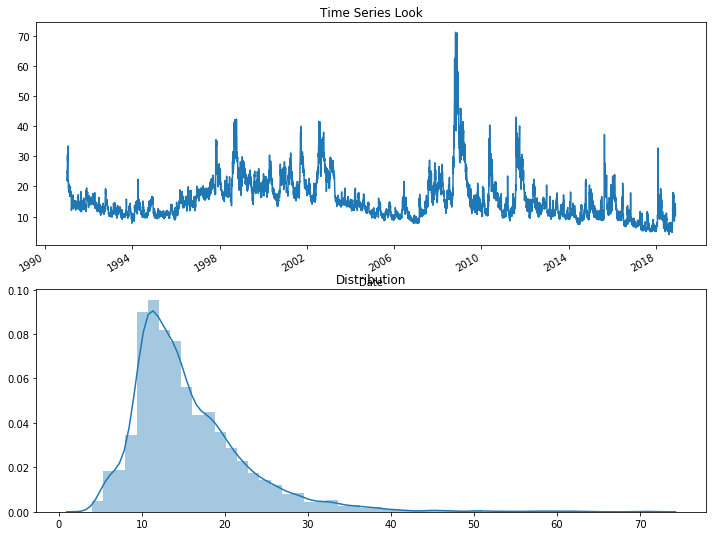

In [37]:
plot_factor(VRP)

## IC (Implied Correlation)

In [38]:
df = pd.read_csv(dataset_path + "SP500_IMPCOR.csv",parse_dates=[0],index_col=0).sort_index()
df.index.rename("Date",inplace=True)
df_ = pd.DataFrame(columns=df.columns[2:])

In [39]:
def compute_spot(x , exp_date):
    date = x.name
    try:
        discount_factor = np.exp( -(exp_date-date).days/365 * bond_yield_3m.loc[date]/100)
        return discount_factor * x[0]
    except:
        return np.nan

In [40]:
for col in df.columns[2:]:
    exp = pd.to_datetime(col[-4:]+'-01-01')
    df_.loc[:,col] = df.loc[:,[col]].apply(lambda x:compute_spot(x,exp),axis=1)

In [41]:
IC = df_.mean(axis=1).dropna()

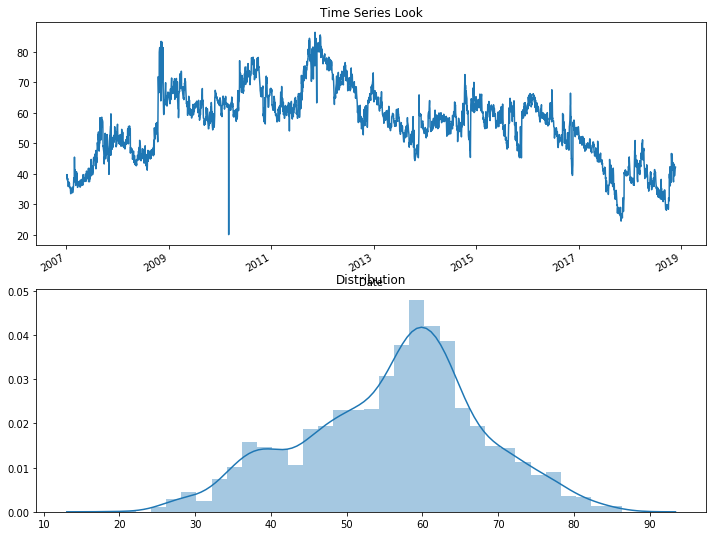

In [42]:
plot_factor(IC)

## BDI (Baltic Dry Index)
$$ BDI = \frac{\text{Baltic Dry Index}}{\text{Baltic Dry Index 3 month age}} - 1$$

In [43]:
df = pd.read_csv(dataset_path + "BDI&GSCI.csv",parse_dates=[0],index_col=0).sort_index()
df.index.rename("Date",inplace=True)

In [44]:
bdi = df.iloc[:,0].astype(float)

In [45]:
gsci = df.iloc[:,1].astype(float)

In [46]:
BDI = (bdi/bdi.shift(66) - 1).dropna()

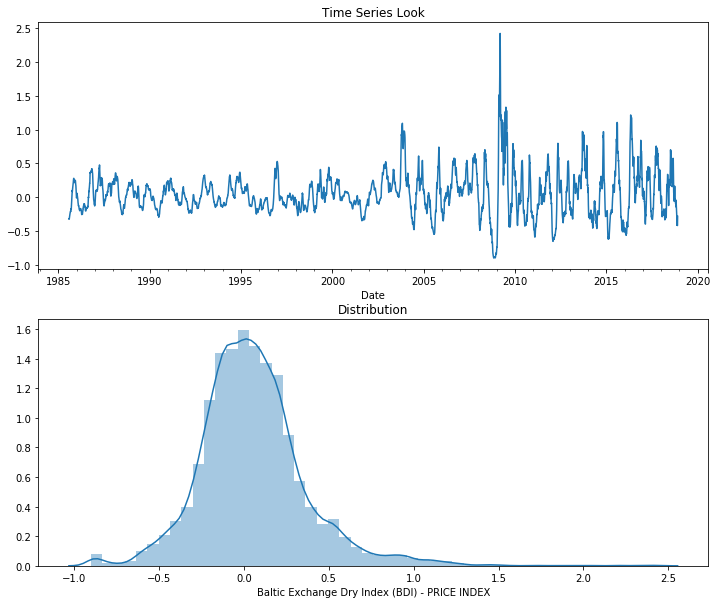

In [47]:
plot_factor(BDI)

## NOS (New Orders/ Shipments)

In [48]:
no = pd.read_csv(dataset_path + "NewOrder.csv",parse_dates=[0],index_col=0).sort_index().UMTMNO
s = pd.read_csv(dataset_path + "Shipment.csv",parse_dates=[0],index_col=0).sort_index().UMTMVS

In [49]:
NOS = (no/s).dropna()
NOS.index.rename("Date",inplace=True)

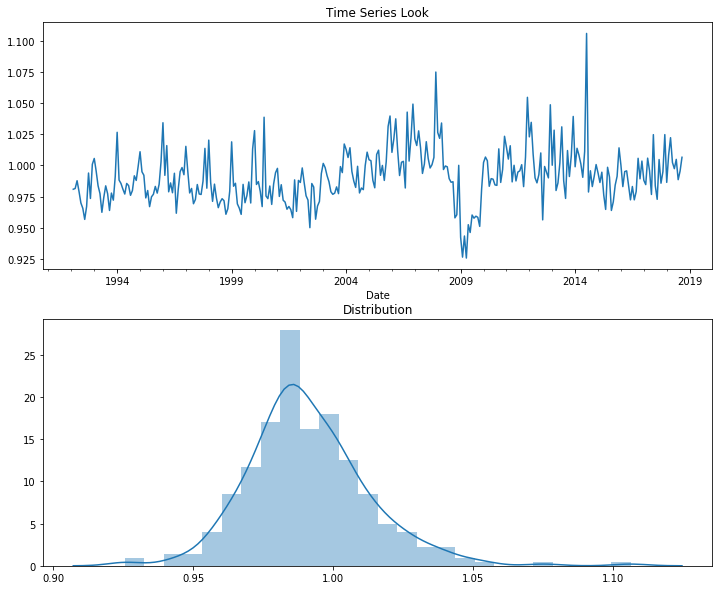

In [50]:
plot_factor(NOS)

## CPI (Consumer Price Index)

$$CPI = \text{change in Consumer Price Index over the last twelve months}$$

In [51]:
df = pd.read_csv(dataset_path + "Consume_Price_Index.csv",parse_dates=[0],index_col=0).sort_index()
cpi = df.Value.astype(float)
CPI = (cpi/cpi.shift(12)-1).dropna()

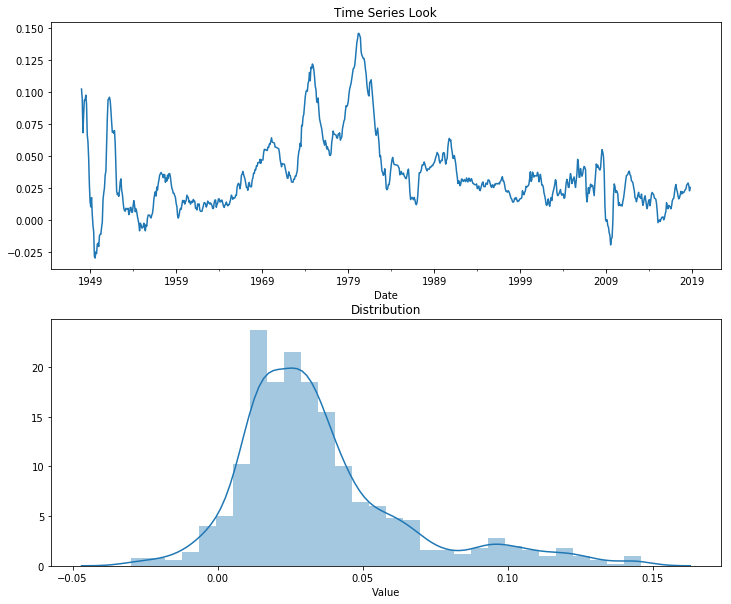

In [52]:
plot_factor(CPI)

## PCR (Ratio of Stock Price to Commodity Price)
$$PCR = \log \frac{SPY}{GSCI}$$

In [53]:
PCR = np.log((spx.Close/gsci).dropna())

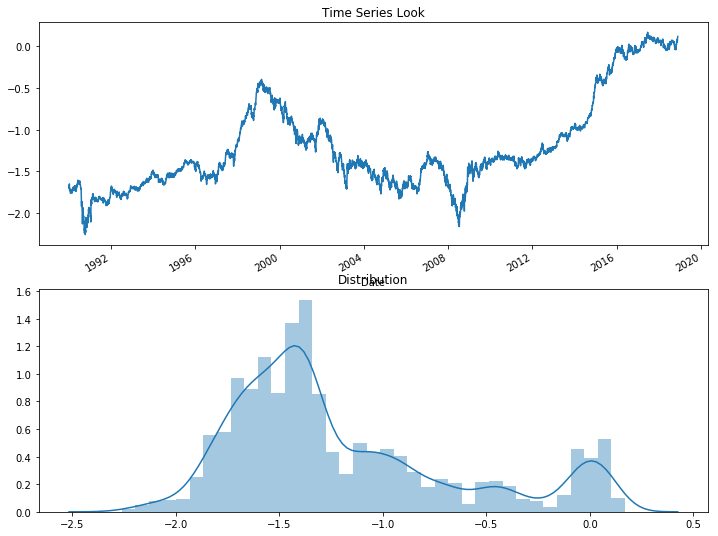

In [54]:
plot_factor(PCR)

## MA (Moving Average)
$$MA = 
\begin{cases} 
1, \text{ if SPX $>$ SPX 10-Month Moving Average }\\
0, \text{otherwise}
\end{cases}$$

In [55]:
MA = ((spx["Adj Close"] - spx["Adj Close"].rolling(20*10).mean()).dropna()>0).astype(int)

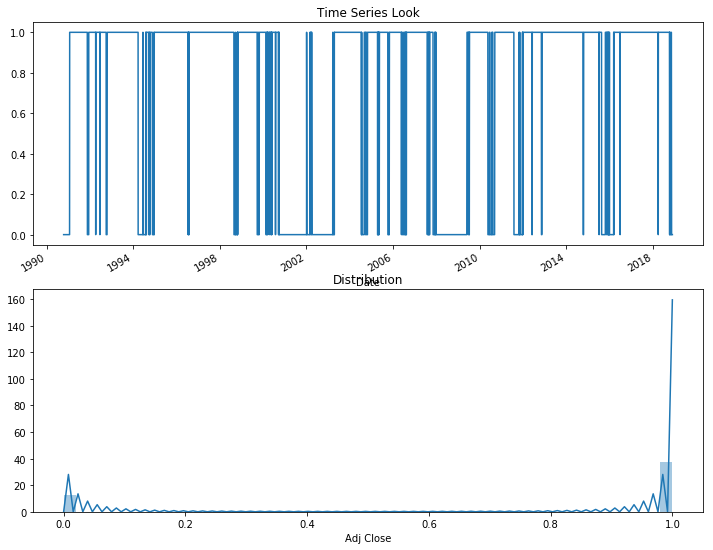

In [56]:
plot_factor(MA)

## PCA-tech

In [57]:
PCA_tech = pd.Series(np.nan,index=DP.index)

In [58]:
plot_factor(PCA_tech)

## OIL (Oil Price Shocks)
$$OIL = log(\text{CL1}) - log(\text{CL4 with 3 months lag})$$

In [59]:
cl1 = pd.read_csv(dataset_path + "EIA-PET_RCLC1_D.csv",parse_dates=[0],index_col=0).sort_index().Value
cl4 = pd.read_csv(dataset_path + "EIA-PET_RCLC4_D.csv",parse_dates=[0],index_col=0).sort_index().Value

In [60]:
OIL = (np.log(cl1) - np.log(cl4.shift(60))).dropna()

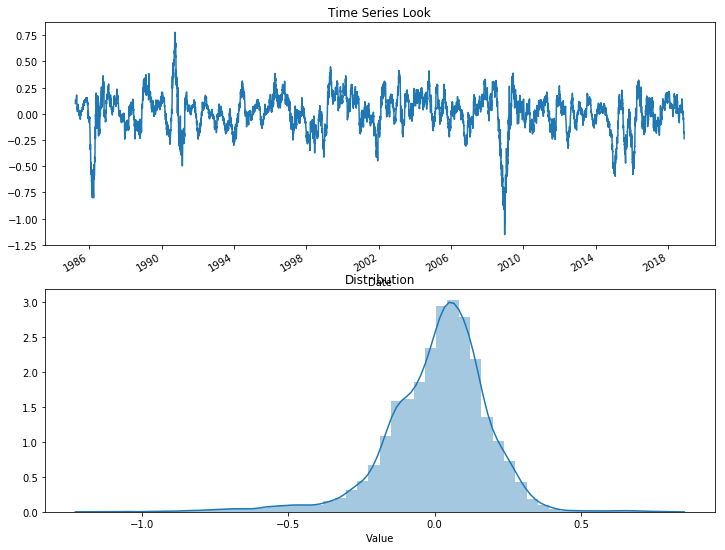

In [61]:
plot_factor(OIL)

## SI (Short Interest)
$$SI = \frac{\text{the sum of all shares short on the NYSE}}{\text{the average daily trading volume over the past 30 days}}$$

In [62]:
si = pd.read_csv(dataset_path + "Short_Interest.csv",parse_dates=[0],index_col=0).sort_index()

In [63]:
SI = (si.ShortVolume/si.TotalVolume.rolling(21).mean()).dropna()

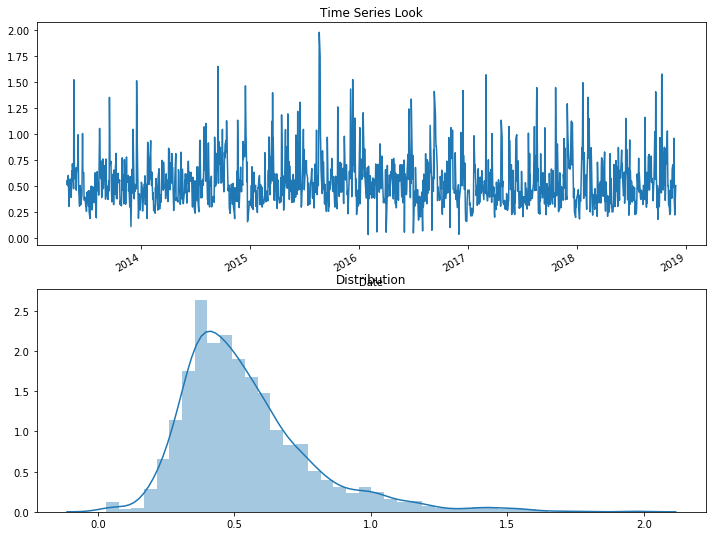

In [64]:
plot_factor(SI)

## R (Future Return on the S&P 500)

In [65]:
lnsp = np.log(spx.Close)

R_1M = lnsp.shift(-20) - lnsp 
R_3M = lnsp.shift(-60) - lnsp
R_6M = lnsp.shift(-120) - lnsp
R_12M = lnsp.shift(-240) - lnsp
R_130d = lnsp.shift(-130) - lnsp

# Merge and Output

In [66]:
factors = pd.concat([DP,PE,BM,CAPE,PCA_price,BY,DEF,TERM,CAY,SIM,VRP,IC,BDI,NOS,CPI,PCR,MA,PCA_tech,OIL,SI],axis=1)
factors.columns = ["DP","PE","BM","CAPE","PCA_price","BY","DEF","TERM","CAY","SIM","VRP",
                   "IC","BDI","NOS","CPI","PCR","MA","PCA_tech","OIL","SI"]
#factors = factors.ffill()
#factors = factors.loc["1990-06-08":]
factors.to_pickle("FactorData/factors.pkl")

In [67]:
returns = pd.concat([R_1M,R_3M,R_6M,R_12M,R_130d],axis=1)
returns.columns = ["R_1M","R_3M","R_6M","R_12M", "R_130d"]
returns.to_pickle("FactorData/returns.pkl")